# Liquid Neural Network

Liquid Neural Networks (LNNs) are a type of neural network architecture that is designed to be much more robust and adaptable than traditional neural networks. LNNs are inspired by the fluid dynamics of liquids, which allows them to process data in a way that is similar to how liquids flow through a container.

In [1]:
%pip install torch matplotlib 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

class LiquidLayer(nn.Module):
    """
    Implements LNN Layer

    this layer processes time series data using continuous-time dynamics,
    allowing for adaptive computation based on the input complexity. 

    attributes:
    - W (nn.Parameter): weight matrix for input transformation
    - omega (nn.Parameter): frequency parameter for oscillatory dynamics
    - alpha (nn.Parameter): scaling parameter for input influence
    - beta (nn.Parameter): scaling parameter for state influence
    """
    def __init__(self, in_features, out_features):
        super(LiquidLayer, self).__init__()
        self.W = nn.Parameter(torch.randn(in_features, out_features))
        self.omega = nn.Parameter(torch.randn(out_features))
        self.alpha = nn.Parameter(torch.randn(out_features))
        self.beta = nn.Parameter(torch.randn(out_features))

    def forward(self, x, dt):
        """
        forward pass for LNN layer

        Args:
        - x (torch.Tensor): input tensor of shape (batch_size, seq_len, in_features)
        - dt (float): time step for numerical integration

        Returns:
        - torch.Tensor: output tensor of shape (batch_size, seq_len, out_features)
        """
        batch_size, seq_len, in_features = x.shape
        state = torch.zeros(batch_size, self.W.shape[1], device=x.device)
        
        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            state = state + dt * (torch.tanh(x_t @ self.W * self.alpha + state * self.beta) + state * self.omega)
            outputs.append(state)
        
        return torch.stack(outputs, dim=1)

class LiquidNet(nn.Module):
    """
    implements a complete LNN

    this network consists of a Liquid Layer followed by a linear readout layer.

    Attributes:
    - liquid (LiquidLayer): the main liquid neural network layer
    - readout (nn.Linear): a linear layer for producing the final output.
    """
    def __init__(self, in_features, hidden_features, out_features):
        super(LiquidNet, self).__init__()
        self.liquid = LiquidLayer(in_features, hidden_features)
        self.readout = nn.Linear(hidden_features, out_features)

    def forward(self, x, dt):
        """
        forward pass of the Liquid Neural Network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, in_features).
            dt (float): Time step for numerical integration.
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, out_features).
        """
        liquid_out = self.liquid(x, dt)
        return self.readout(liquid_out)


In [3]:
def generate_sample_data(num_samples, seq_length):
    """
    generates synthetic time series data for training and testing. 

    Arguments:
    - num_samples (int): number of samples in the dataset.
    - seq_len (int): length of each time series sequence

    Returns:
    - tuple: a tuple containing input data x and target data y, both of
            (num_samples, seq_len)
    """
    t = torch.linspace(0, 10, seq_length).unsqueeze(0).unsqueeze(2).repeat(num_samples, 1, 1)
    x = torch.sin(t) + 0.1 * torch.randn(num_samples, seq_length, 1)
    y = torch.sin(2 * t) + 0.1 * torch.randn(num_samples, seq_length, 1)
    return x, y

def train(model, x, y, num_epochs, lr):
    """
    trains the Liquid Neural Network model.
    
    Args:
        model (LiquidNet): The model to be trained.
        x (torch.Tensor): Input data.
        y (torch.Tensor): Target data.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
    """
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    dt = 0.1
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(x, dt)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [4]:
# training loop
epochs = 1000
num_samples = 100
seq_len = 100

x, y = generate_sample_data(num_samples, seq_len)

model = LiquidNet(in_features=1, hidden_features=32, out_features=1)

train(model, x, y, num_epochs=epochs, lr=0.01) 


Epoch [100/1000], Loss: 6204.3486
Epoch [200/1000], Loss: 5271.2168
Epoch [300/1000], Loss: 4030.1528
Epoch [400/1000], Loss: 1025.0597
Epoch [500/1000], Loss: 240.0423
Epoch [600/1000], Loss: 91.3111
Epoch [700/1000], Loss: 62.9495
Epoch [800/1000], Loss: 54.2803
Epoch [900/1000], Loss: 48.5952
Epoch [1000/1000], Loss: 43.9041


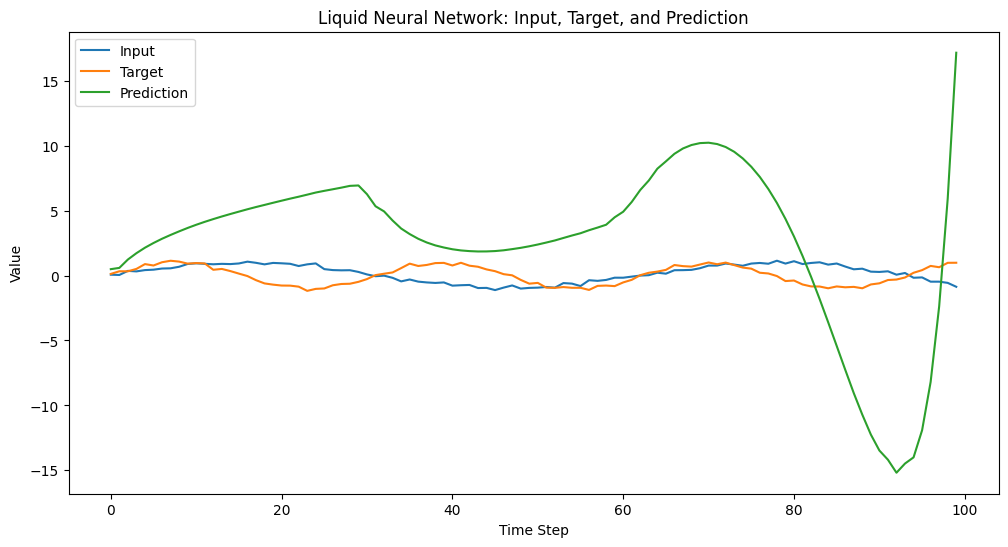

In [5]:
# plot results
with torch.no_grad():
    dt = 0.1
    pred = model(x, dt)

plt.figure(figsize=(12, 6))
plt.plot(x[0, :, 0].numpy(), label='Input')
plt.plot(y[0, :, 0].numpy(), label='Target')
plt.plot(pred[0, :, 0].numpy(), label='Prediction')
plt.legend()
plt.title('Liquid Neural Network: Input, Target, and Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()
